Previous failed attempts showed that loading a lot of data is computationally bad. So this notebook is to develop and test methods on partition 5 of the data.

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
def weighted_r2(y_true, y_pred, w):
    return 1 - np.sum(w * (y_true - y_pred)**2) / np.sum(w * y_true**2)

In [3]:
path = '/kaggle/input/jane-street-real-time-market-data-forecasting'

feature_cols = [f'feature_{i:02d}' for i in range(79)]
feature_cols = [c for c in feature_cols if c not in ['feature_09', 'feature_10', 'feature_11']]
target = 'responder_6'

Reduce memory as before. 

In [4]:

## found this function from another notebook to reduce memory - aggressive but ok
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == object or str(col_type) == 'category':
            continue
        c_min, c_max = df[col].min(), df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        else:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    return df

def load_partition(i):
    df = pd.read_parquet(f'{path}/train.parquet/partition_id={i}/part-0.parquet')
    df[feature_cols] = df[feature_cols].fillna(0).astype('float32')
    df = reduce_mem_usage(df)
    return df



## The main approach

Take partition 5 of the data. We'll train on 80% of the partition and test on remaing 20%. Finetune things and test the model on parition 6 of the data. This way we can get a sense of how model does on data that is slightly not from immediate future.

In [6]:
part5 = load_partition(5)


dates = sorted(part5['date_id'].unique())
cutoff = dates[int(len(dates)*0.8)]

train= part5[part5['date_id'] <= cutoff].reset_index(drop=True)
val = part5[part5['date_id'] > cutoff].reset_index(drop=True)
test = load_partition(6)

print(f"train: {train.shape}, val: {val.shape}, test: {test.shape}")

train: (4229192, 92), val: (1119008, 92), test: (6203912, 92)


Training has about 3.6M rows. 

In [8]:
## plan is drop the discrete variables
feature_cols = [c for c in feature_cols if c not in ['feature_09', 'feature_10', 'feature_11']]

## Idea 1 : baseline global model first + symbol specific residual-trained model

Based on past experience, to keep the model simple and within memory constraints, I am dropping the discrete features and considering only the top 30 correlated features from the remaining ones. Then I am building rolling stats features for top 10 correlated features and averages for all.



In general, the basic model idea is first build a baseline and see how it performs. If it doesn't perform well, we model residuals for specific symbols, build different models for different residuals, and see if that can improve performance.

In [9]:
def feature_engineering(train, val, top_corr=30, top_avg=30, top_roll=10):
    corrs = train[feature_cols].corrwith(train[target]).abs().sort_values(ascending=False)
    top_feats = corrs.head(top_corr).index.tolist()
    avg_feats = corrs.head(top_avg).index.tolist()
    roll_feats_cols = corrs.head(top_roll).index.tolist()
    
    # market averages
    mkt_avg = train.groupby(['date_id', 'time_id'])[avg_feats].mean().add_prefix('mkt_avg_')
    train = train.merge(mkt_avg, on=['date_id', 'time_id'], how='left')
    val = val.merge(mkt_avg, on=['date_id', 'time_id'], how='left')
    
    # rolling stats
    roll_feats = []
    for feat in roll_feats_cols:
        for df in [train, val]:
            df[f'{feat}_roll_mean'] = df.groupby('symbol_id')[feat].transform(lambda x: x.rolling(1000, min_periods=1).mean())
            df[f'{feat}_roll_std'] = df.groupby('symbol_id')[feat].transform(lambda x: x.rolling(1000, min_periods=1).std().fillna(0))
        roll_feats += [f'{feat}_roll_mean', f'{feat}_roll_std']
    
    final_feats = top_feats + list(mkt_avg.columns) + roll_feats + ['symbol_id', 'time_id']
    
    cols_to_keep = final_feats + ['date_id', 'weight', target]
    train = train[cols_to_keep]
    val = val[cols_to_keep]
    
    return train, val, final_feats

For the first run, I am only considering top 10 correlated features. 

In [10]:
train, val, feats = feature_engineering(train, val, 10,10,5)

In [15]:
X_train, y_train, w_train = train[feats], train[target], train['weight']
X_val, y_val, w_val = val[feats], val[target], val['weight']

X_train.columns

Index(['feature_06', 'feature_60', 'feature_04', 'feature_36', 'feature_58',
       'feature_59', 'feature_49', 'feature_07', 'feature_12', 'feature_45',
       'mkt_avg_feature_06', 'mkt_avg_feature_60', 'mkt_avg_feature_04',
       'mkt_avg_feature_36', 'mkt_avg_feature_58', 'mkt_avg_feature_59',
       'mkt_avg_feature_49', 'mkt_avg_feature_07', 'mkt_avg_feature_12',
       'mkt_avg_feature_45', 'feature_06_roll_mean', 'feature_06_roll_std',
       'feature_60_roll_mean', 'feature_60_roll_std', 'feature_04_roll_mean',
       'feature_04_roll_std', 'feature_36_roll_mean', 'feature_36_roll_std',
       'feature_58_roll_mean', 'feature_58_roll_std', 'symbol_id', 'time_id'],
      dtype='object')

## LGBM global model

In [16]:

lgbm = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=64, n_jobs=-1)
lgbm.fit(X_train, y_train, sample_weight=w_train,
         eval_set=[(X_val, y_val)], eval_sample_weight=[w_val],
         callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

lgbm_preds = lgbm.predict(X_val)
print(f"LGBM R²: {weighted_r2(y_val.values, lgbm_preds, w_val.values):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7941
[LightGBM] [Info] Number of data points in the train set: 4229192, number of used features: 32
[LightGBM] [Info] Start training from score -0.007691
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.729157
[100]	valid_0's l2: 0.72889
[150]	valid_0's l2: 0.728832
[200]	valid_0's l2: 0.728777
Early stopping, best iteration is:
[174]	valid_0's l2: 0.728474
LGBM R²: 0.005559


Way better than earlier. Let's see performance for specific symbol (Symbol = 2).

In [17]:
sym_mask = train['symbol_id'] == 2
xx = train[sym_mask].index.values

# actual
yy_actual = train[sym_mask]['responder_6'].values

# predicted
yy_pred = lgbm.predict(X_train)[sym_mask]

print(f"actual mean: {yy_actual.mean():.4f}, std: {yy_actual.std():.4f}")
print(f"pred mean:   {yy_pred.mean():.4f}, std: {yy_pred.std():.4f}")

actual mean: -0.0126, std: 0.7352
pred mean:   -0.0109, std: 0.1134


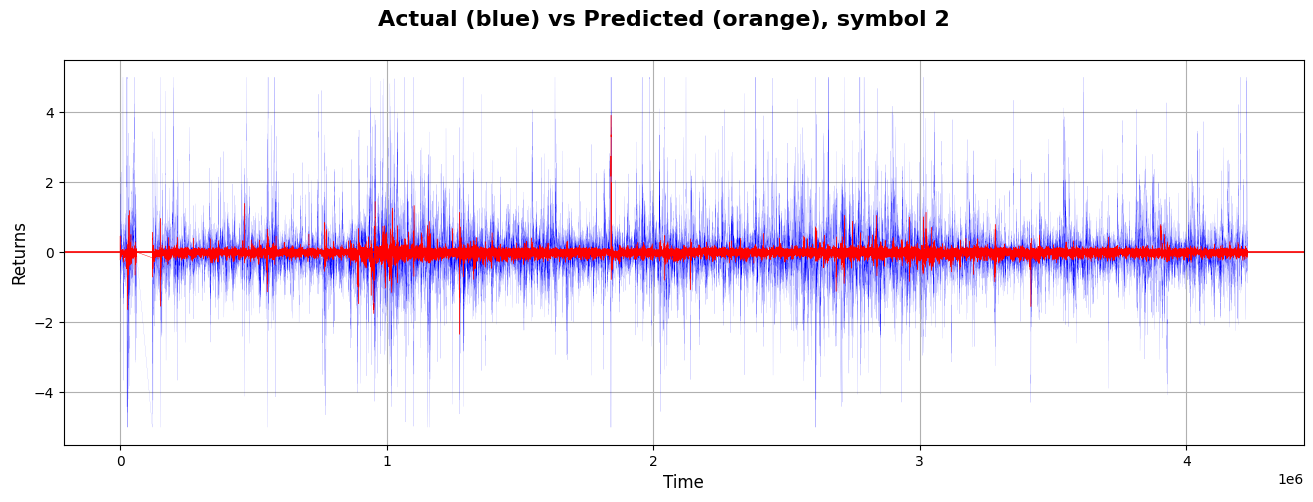

In [18]:
plt.figure(figsize=(16, 5))
plt.plot(xx, yy_actual, color='blue', linewidth=0.05)
plt.plot(xx, yy_pred, color='red', linewidth=0.3)
plt.suptitle('Actual (blue) vs Predicted (orange), symbol 2', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(linewidth=0.8)
plt.axhline(0, color='red', linestyle='-', linewidth=1.2)
plt.show()

Better than before. It can identify some extreme peaks. Not bad.

Let's see how the model does on a different symbol. (Symbol 7)

In [19]:
sym_mask = train['symbol_id'] == 7
xx = train[sym_mask].index.values

# actual
yy_actual = train[sym_mask]['responder_6'].values

# predicted
yy_pred = lgbm.predict(X_train)[sym_mask]

print(f"actual mean: {yy_actual.mean():.4f}, std: {yy_actual.std():.4f}")
print(f"pred mean:   {yy_pred.mean():.4f}, std: {yy_pred.std():.4f}")

actual mean: -0.0090, std: 0.8385
pred mean:   -0.0102, std: 0.1211


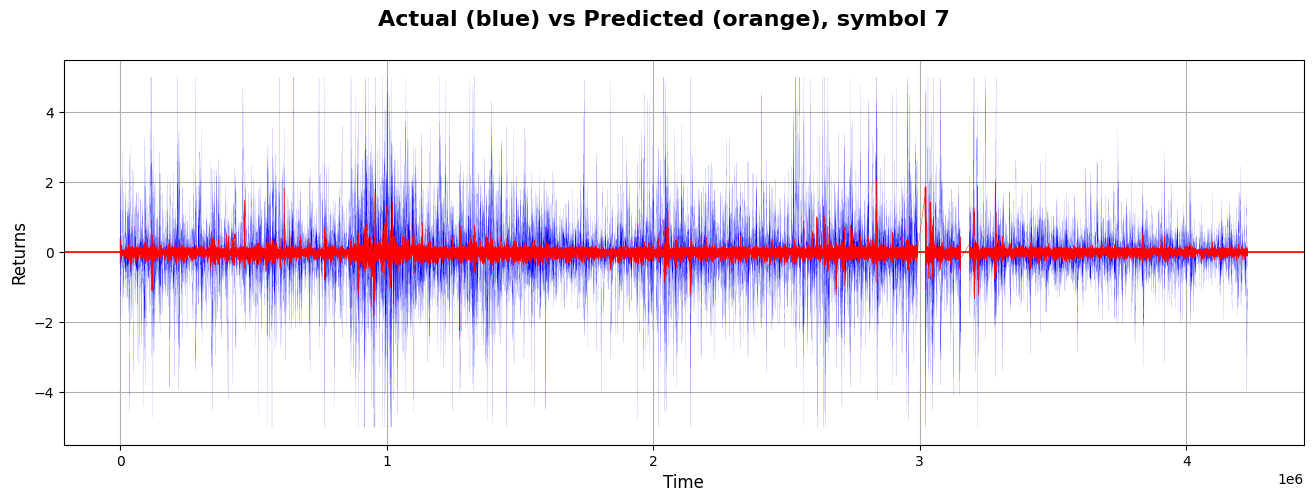

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(xx, yy_actual, color='blue', linewidth=0.05)
plt.plot(xx, yy_pred, color='red', linewidth=0.3)
plt.suptitle('Actual (blue) vs Predicted (orange), symbol 7', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(linewidth=0.8)
plt.axhline(0, color='red', linestyle='-', linewidth=1.2)
plt.show()

So far, this is much better than what we had earlier. Let's test how well the modl generalisaes.

XGBoost won't beat this. 

In [ ]:
"""##XGBOOST
xgb_model = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    n_jobs=-1, tree_method='hist',
    early_stopping_rounds=50
)
xgb_model.fit(X_train, y_train, sample_weight=w_train,
              eval_set=[(X_val, y_val)],
              verbose=50)

xgb_preds = xgb_model.predict(X_val)
print(f"XGBoost R²: {weighted_r2(y_val.values, xgb_preds, w_val.values):.6f}")"""

In [ ]:
"""sym1_mask_val = val1['symbol_id'] == 1
xx_val = val1[sym1_mask_val].index.values
yy_val_actual = val1[sym1_mask_val]['responder_6'].values
yy_val_pred = xgb_preds[sym1_mask_val]

plt.figure(figsize=(16, 5))
plt.plot(xx_val, yy_val_actual, color='blue', linewidth=0.05)
plt.plot(xx_val, yy_val_pred, color='orange', linewidth=0.3)
plt.suptitle('Actual (blue) vs Predicted (orange), symbol 1 - XGBoost', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(linewidth=0.8)
plt.axhline(0, color='red', linestyle='-', linewidth=1.2)
plt.show()"""

## Are the features for different symbols scaled differently ?


We can standardize the feature otherwise.


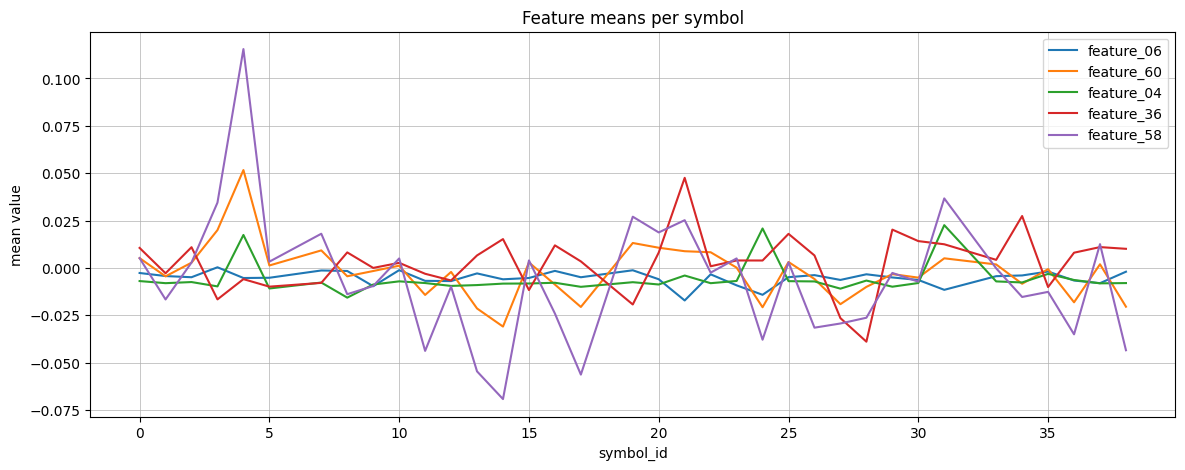

In [21]:
top5 = feats[:5]
sym_means = train.groupby('symbol_id')[top5].mean()

sym_means.plot(figsize=(14, 5), title='Feature means per symbol')
plt.xlabel('symbol_id')
plt.ylabel('mean value')
plt.legend(loc='upper right')
plt.grid(linewidth=0.5)
plt.show()

It seems like symbol 4 features are slightly larger. Overall it does not look too bad,

### Residuals within symbols


In [24]:
global_preds = lgbm.predict(val[feats])
global_resid = val[target].values - global_preds

for sym in sorted(val['symbol_id'].unique()):
    mask = val['symbol_id'] == sym
    sym_resid = global_resid[mask]
    print(f"symbol {sym:2d}: mean={sym_resid.mean():.4f}, std={sym_resid.std():.4f}")

symbol  0: mean=-0.0156, std=0.6110
symbol  1: mean=-0.0061, std=0.5687
symbol  2: mean=0.0111, std=0.7747
symbol  3: mean=0.0133, std=0.8012
symbol  4: mean=0.0021, std=0.8472
symbol  5: mean=-0.0141, std=0.8201
symbol  7: mean=-0.0120, std=0.6569
symbol  8: mean=0.0190, std=0.8061
symbol  9: mean=-0.0195, std=0.9011
symbol 10: mean=0.0086, std=0.7858
symbol 11: mean=-0.0004, std=0.8536
symbol 12: mean=-0.0093, std=0.9356
symbol 13: mean=0.0137, std=0.7161
symbol 14: mean=0.0456, std=0.9001
symbol 15: mean=0.0301, std=1.0856
symbol 16: mean=-0.0290, std=0.6746
symbol 17: mean=-0.0013, std=0.8067
symbol 19: mean=-0.0004, std=0.6828
symbol 20: mean=-0.0015, std=0.8035
symbol 21: mean=0.0030, std=1.0159
symbol 22: mean=0.0244, std=0.9222
symbol 23: mean=-0.0165, std=0.8489
symbol 24: mean=-0.0280, std=0.9812
symbol 25: mean=0.0466, std=1.1595
symbol 26: mean=-0.0163, std=0.9599
symbol 27: mean=0.0688, std=1.0519
symbol 28: mean=0.0443, std=1.0291
symbol 29: mean=0.0469, std=1.0647
symbol

Doesn't seem to crazy at first sight.

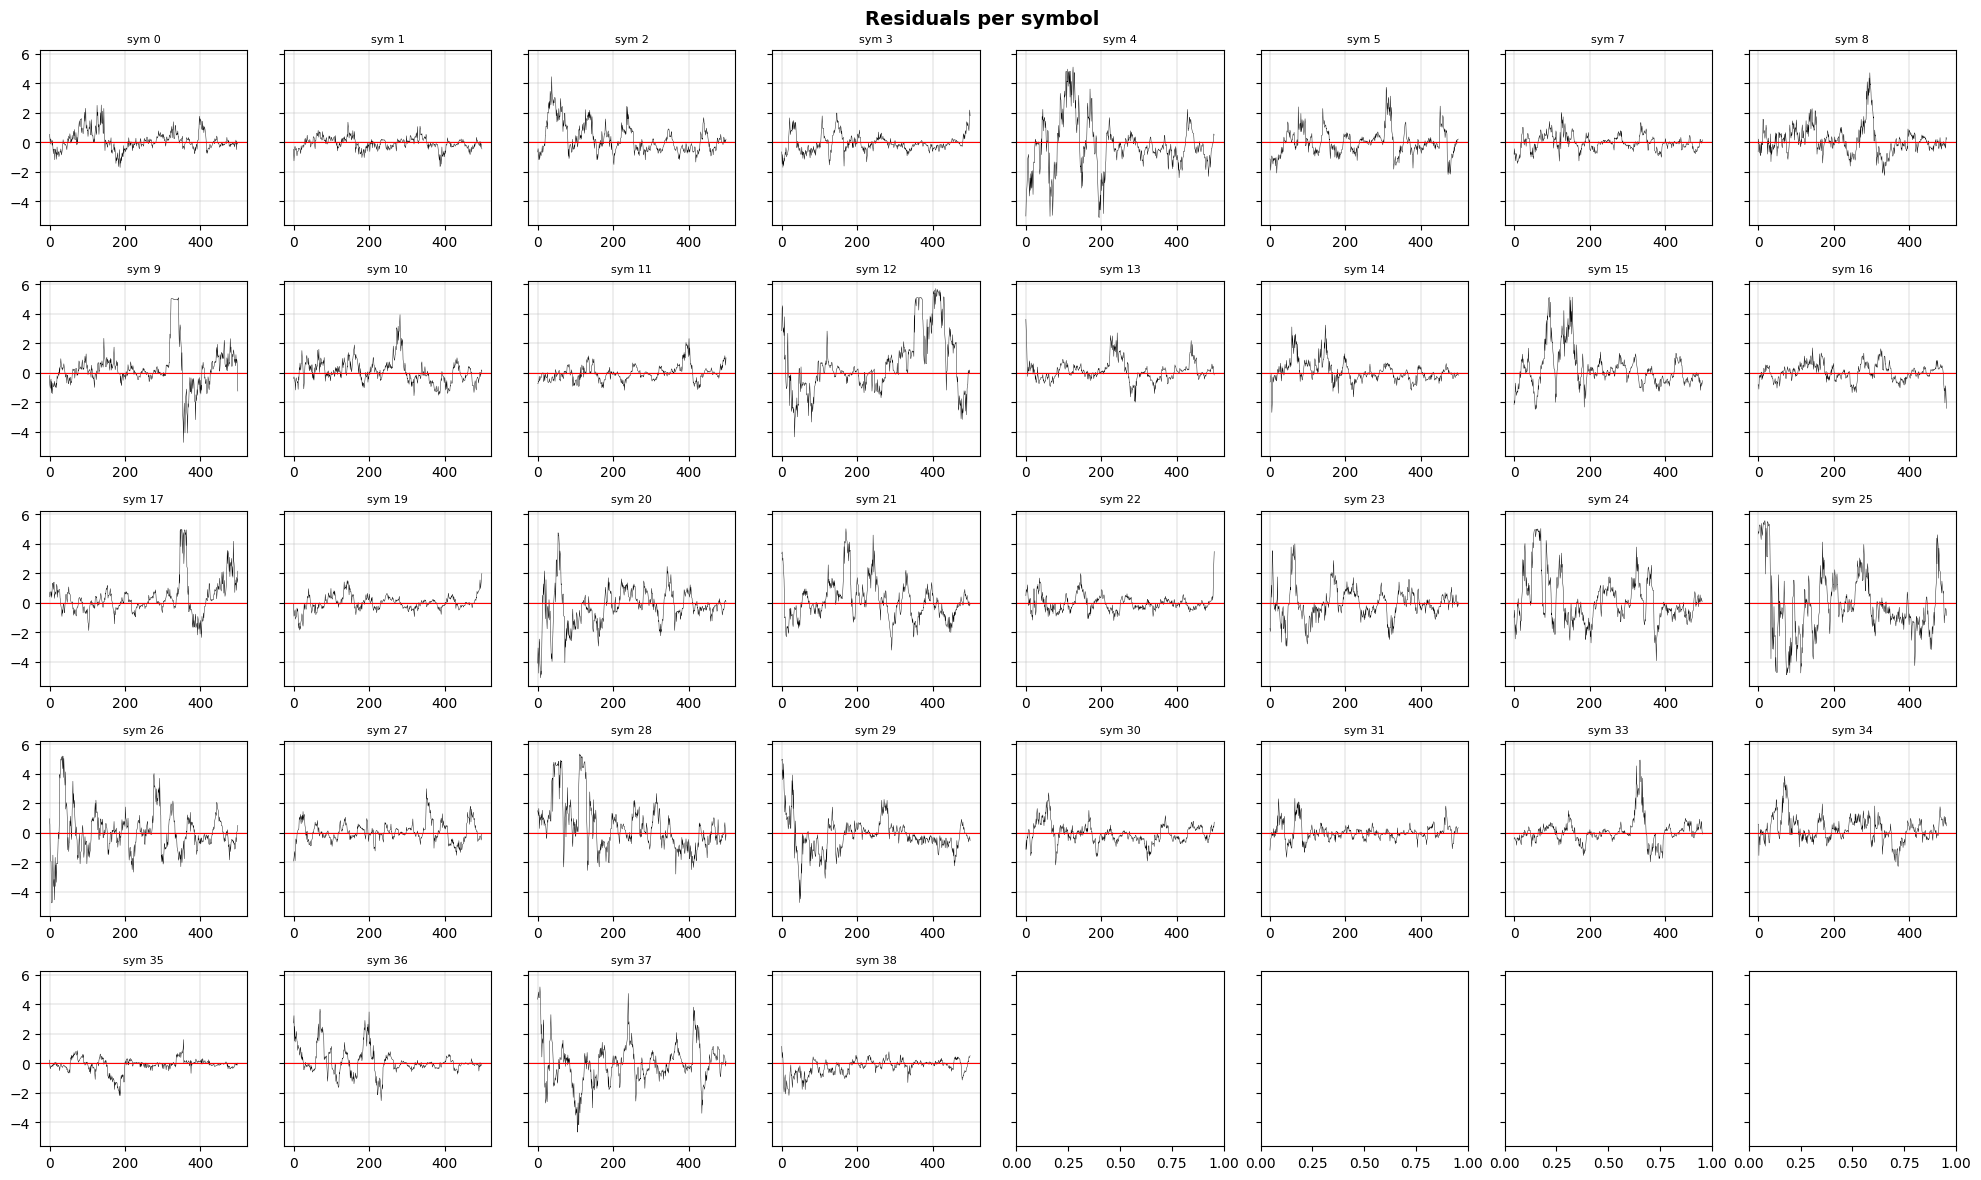

In [28]:
fig, axes = plt.subplots(5, 8, figsize=(20, 12), sharey=True)
axes = axes.flatten()

for idx, sym in enumerate(sorted(val['symbol_id'].unique())):
    mask = val['symbol_id'] == sym
    sym_resid = global_resid[mask]
    axes[idx].plot(sym_resid[:500], color='black', linewidth=0.3)
    axes[idx].axhline(0, color='red', linewidth=0.8)
    axes[idx].set_title(f'sym {sym}', fontsize=8)
    axes[idx].grid(linewidth=0.3)

plt.suptitle('Residuals per symbol', weight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## Symbol-specific Residual modelling

Most symbols look decent — residuals centered around zero, random noise. But a few stand out:

Symbol 4 — large spikes, high variance residuals. Model struggling here
Symbol 12 — some drift visible
Symbol 17 — spikes
Symbol 28 — volatile 

Will just model residuals seperataly for these symbols.

In [32]:
resid_train = train[target].values - lgbm.predict(train[feats])

problem_syms = [4, 12, 17, 28]

symbol_models = {}
for sym in problem_syms:
    sym_mask_train = (train['symbol_id'] == sym).values
    
    m = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, num_leaves=32, n_jobs=-1)
    m.fit(train[feats][sym_mask_train], resid_train[sym_mask_train],
          sample_weight=train['weight'].values[sym_mask_train])
    symbol_models[sym] = m
    print(f"trained symbol {sym}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 25168, number of used features: 31
[LightGBM] [Info] Start training from score -0.018438
trained symbol 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 129712, number of used features: 31
[LightGBM] [Info] Start training from score 0.005110
trained symbol 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

In [33]:
resid_preds = np.zeros(len(val))
for sym, m in symbol_models.items():
    mask = (val['symbol_id'] == sym).values
    resid_preds[mask] = m.predict(val[feats][mask])

final_preds = global_preds + 0.5*resid_preds
print(f"Global + Symbol residual R²: {weighted_r2(val[target].values, final_preds, val['weight'].values):.6f}")

Global + Symbol residual R²: 0.001538


This is really bad. The symbol specific ones are trying to fit too much on the noise. 

### Global residual model

Let's see if we can resduce the noise modelling by doing gloabl residual fit.

In [35]:


lgbm_resid_global = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=32, n_jobs=-1)
lgbm_resid_global.fit(train[feats], resid_train, sample_weight=train['weight'],
                      eval_set=[(val[feats], val[target] - global_preds)], eval_sample_weight=[val['weight']],
                      callbacks=[lgb.early_stopping(20), lgb.log_evaluation(50)])

final_preds = global_preds + 0.5*lgbm_resid_global.predict(val[feats])
print(f"Global + residual R²: {weighted_r2(val[target].values, final_preds, val['weight'].values):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7941
[LightGBM] [Info] Number of data points in the train set: 4229192, number of used features: 32
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.728494
Global + residual R²: 0.005550


Slight reduction from baseline. Maybe there is too much noise in the residuals. SO we should probably try to improve baseline and that should do better.

# Modeling Summary

## Setup
- Data: Jane Street Real-Time Market Data Forecasting
- Training: Partition 5 (60/20 train/val split), Test: Partition 6
- Features: Top 30 correlated features + market averages + rolling stats (window=1000)
- Target: responder_6, metric: weighted zero-mean R²

## Feature Engineering
- Dropped categorical features (feature_09/10/11)
- Top 30 correlated features with responder_6
- Market averages per date_id and time_id (top 30 features)
- Rolling mean and std per symbol over last 1000 rows (top 10 features)
- Added symbol_id and time_id as features

## Models and Results

| Model | Val R² | Test R² |
|-------|--------|---------|
| LGBM global | 0.007950 | 0.005559 |
| XGBoost | 0.001577 | — |
| LGBM + LGBM residual | 0.004645 | 0.005550 |
| Global + symbol residuals | — | 0.001538 |

## Key Findings
- LGBM outperforms XGBoost consistently
- Residual modeling didn't improve over plain LGBM
- Symbol-specific residual models overfit on small data
- Model generalizes to near-future data better than lagged data (non-stationarity)
- Val R² drops from 0.008 to 0.006 on test — expected regime shift

## Final Model
Plain global LGBM with symbol_id as categorical feature. Val R²: 0.007950, Test R²: 0.005559.